# Radioactively powered light curves

Anirudh Patel \
anirudh.p@columbia.edu \
8/4/2025

In [1]:
MSUN =  1.9892e33
RSUN = 6.957e10
CLITE = 2.99792458e10 
SEC_TO_DAY = 1/(24 * 3600)
N_A = 6.02214129e23

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import matplotlib
matplotlib.rc_file('matplotlibrc')

In [2]:
#Define some functions we will need

# #specific heating rate of 56Ni decay chain
def qdot_ni(t, eNi = 3.9e10, eCo= 6.8e9, tNi=8.8/SEC_TO_DAY, tCo=111.3/SEC_TO_DAY):
    return (eNi * np.exp(-t/(tNi)) + eCo * (np.exp(-t/(tCo)) - np.exp(-t/(tNi))))

#general solution for Luminosity
def L_solution(t, tpk, source_func):
    t = np.asarray(t)
    L_vals = np.zeros_like(t)

    inv_tpk2 = 1/tpk**2
    integrand = lambda tau: tau * source_func(tau) * np.exp(tau**2 * inv_tpk2)

    for i in range(len(t)):

        # The exponential blows up to infinity for t >> tpk. 
        # The if-statements here work around the numerical instability.
        test_val = integrand(t[i])
        exp_term = np.exp(-t[i]**2 * inv_tpk2)
        if (np.isnan(test_val) or np.isinf(test_val)) or (np.isnan(exp_term) or np.isinf(exp_term)):
            L_vals[i] = source_func(t[i])
            continue
        
        integral_val, _ = quad(integrand, 0, t[i])
       
        L = (integral_val) * 2 * inv_tpk2 * exp_term
        
        if np.isnan(L) or np.isinf(L):
            L_vals[i] = source_func(t[i])
            continue

        L_vals[i] = L

    return np.array(L_vals)

### One Zone Model

In [3]:
# Define fiducial model parameters

M = 1.4 * MSUN # total ejecta mass [g]
Mni = 0.7 * MSUN   #Nickel mass. The nickel mass in the ejecta must be less than the total ejecta mass.
k = 0.2 #opacity [cm^2/g]
vbar = 1e9 #average velocity [cm/s], ~10000 km/s for 1e51 erg explosion

t = np.logspace(0, 9, 5000) # time array [s]

In [4]:
tpk = np.sqrt(k * M/(4 * np.pi * vbar * CLITE)) #the peak time-scale
L_onezone = L_solution(t, tpk, lambda t_val: Mni * qdot_ni(t_val))  #the light curve
Qdot_ni = qdot_ni(t) * Mni #the total radioactive heating rate from 56Ni

/var/folders/l0/_1rsd9w97jl6k1hgpqgqgvn40000gn/T/ipykernel_49272/2835060870.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_val, _ = quad(integrand, 0, t[i])
/var/folders/l0/_1rsd9w97jl6k1hgpqgqgvn40000gn/T/ipykernel_49272/2835060870.py:13: RuntimeWarning: overflow encountered in scalar multiply
  integrand = lambda tau: tau * source_func(tau) * np.exp(tau**2 * inv_tpk2)
/var/folders/l0/_1rsd9w97jl6k1hgpqgqgvn40000gn/T/ipykernel_49272/2835060870.py:13: RuntimeWarning: overflow encountered in exp
  integrand = lambda tau: tau * source_func(tau) * np.exp(tau**2 * inv_t

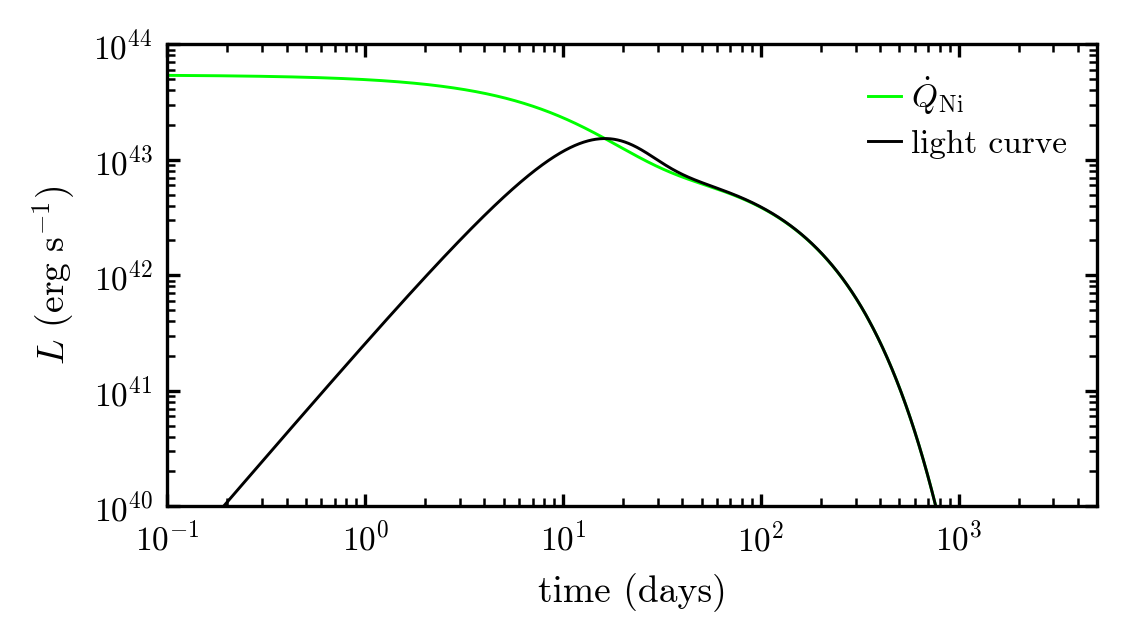

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2.), dpi = 300)

ax.plot(t * SEC_TO_DAY, Qdot_ni, color='lime', linestyle='-', lw = 0.7, label = r'$\dot{Q}_{\rm Ni}$')
ax.plot(t * SEC_TO_DAY, L_onezone, color='black', linestyle='-', lw = 0.7, label = 'light curve')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, 5e3)
ax.set_ylim(1e40, 1e44)
ax.set_xlabel('time (days)')
ax.set_ylabel(r'$L$ ($\rm erg~s^{-1}$)')
ax.legend()

# plt.savefig('onezone.pdf', bbox_inches='tight')
plt.show()

### Multi-Zone Model

In [8]:
#set up grid
N = 50
m_edges = np.linspace(M, 0, N + 1)  # N+1 edges define N grid zones
m = 0.5 * (m_edges[:-1] + m_edges[1:])  # mass coordinate at the center of each zone
dm = M/N # the mass in each zone

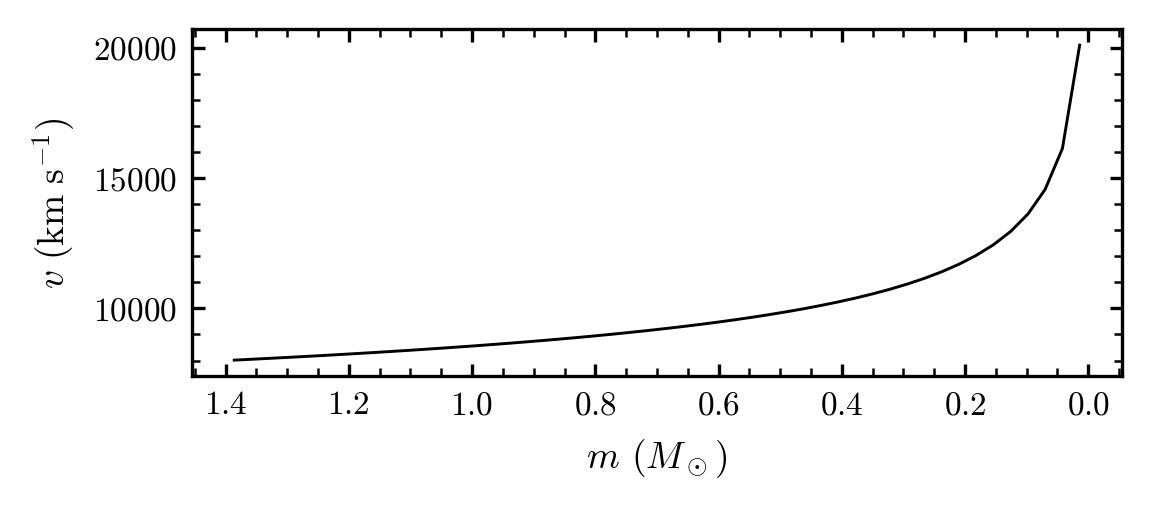

In [ ]:
 # velocity profile
beta = 5
v_profile = (beta-1)/beta * vbar * (m/M)**(-1/(beta))

fig, ax = plt.subplots(figsize=(4, 1.5), dpi = 300)

ax.plot(m/MSUN, v_profile/1e5, color = 'black', lw = 0.7)

ax.set_xlabel(r'$m$ ($M_\odot$)')
ax.set_ylabel(r'$v~\rm (km~s^{-1})$')
ax.invert_xaxis()

# ax.set_ylim(0,8000)
# plt.savefig('v.pdf', bbox_inches='tight')
plt.show()

In [10]:
#radioactive mass distribution function
def X(m, fmix, M_ni, M_tot, chi = 0.1):
    if M_ni >= fmix * M_tot:
        raise ValueError("fmix * M must be greater than M_ni.")
    M_mix = fmix * M_tot
    C = M_ni/(M_tot - chi * M_mix * np.log(np.cosh((M_mix - M_tot)/(chi * M_mix))/np.cosh(1/chi)))
    
    return C * (np.tanh((M_mix - (M-m)) / (chi * M_mix)) + 1)

In [11]:
fmix = 0.501 # parameter determining how far towards the ejecta surace 56Ni is mixed
#!!!NOTE that M*fmix must be greater than the Nickel mass you are putting in. I.E. if you put in 0.5*M nickel, you must have fmix>0.5.
Xni = X(m, fmix, Mni, M) # nickel mass fraction profile
print(np.sum(Xni * dm)/Mni)  # ensure that this gives you the proper Ni mass (i.e., this should print 1)

0.9999999999966676


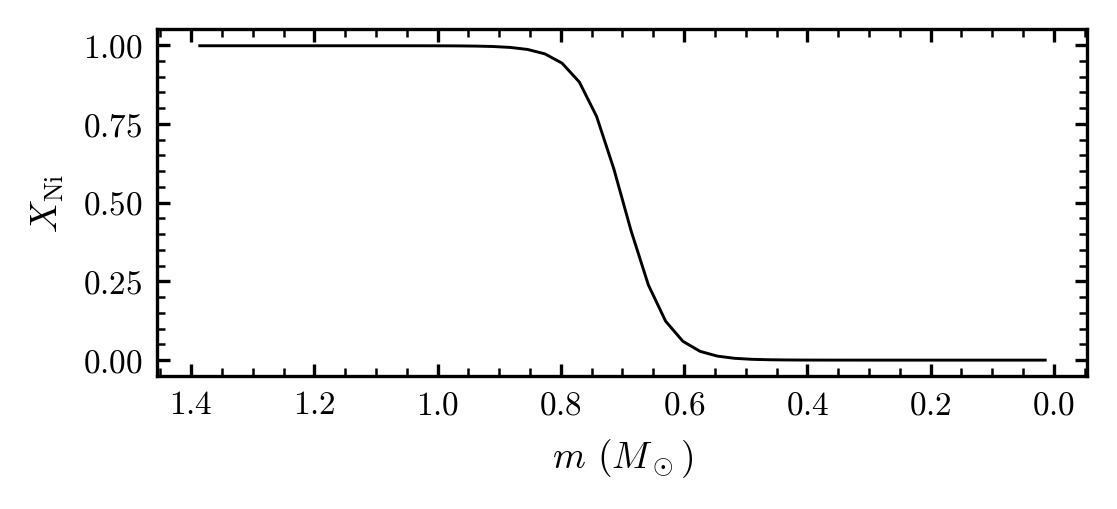

In [ ]:
#Nickel mass fraction
fig, ax = plt.subplots(figsize=(4, 1.5), dpi = 300)

ax.plot(m/MSUN, Xni, color = 'black', lw = 0.7)

ax.set_ylim(-0.05,1.05)
ax.set_xlabel(r'$m$ ($M_\odot$)')
ax.set_ylabel(r'$X_{\rm Ni}$')
ax.invert_xaxis()

# plt.savefig('ni_dist.pdf', bbox_inches='tight')
plt.show()

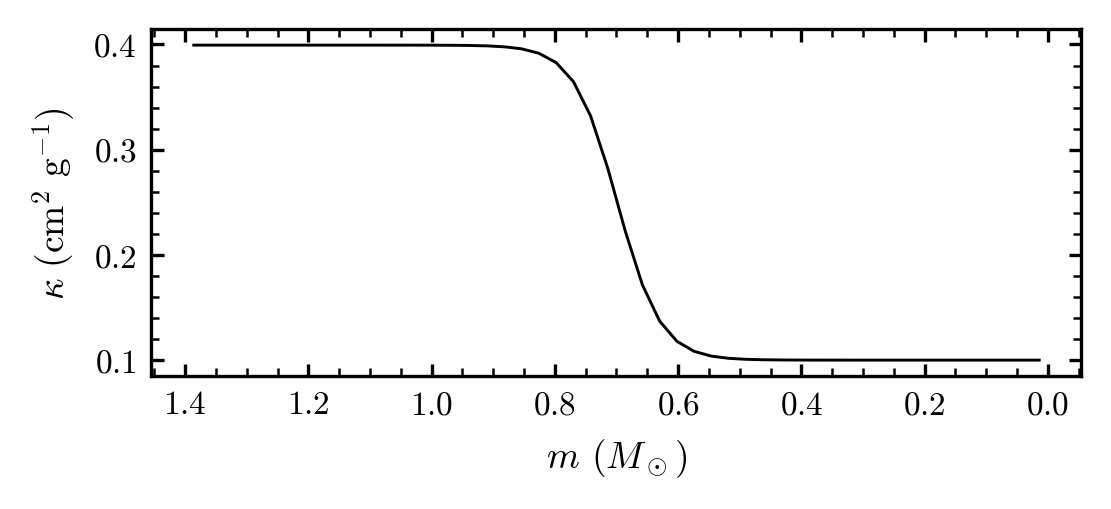

In [ ]:
#opacity profile, k0 = 0.1, k1 = 0.3
k_profile = 0.1 + 0.3 * Xni

fig, ax = plt.subplots(figsize=(4, 1.5), dpi = 300)
ax.plot(m/MSUN, k_profile, color = 'black', lw = 0.7)

ax.set_xlabel(r'$m$ ($M_\odot$)')
ax.set_ylabel(r'$\kappa~\rm (cm^2~g^{-1})$')
ax.invert_xaxis()

# plt.savefig('kappa.pdf', bbox_inches='tight')
plt.show()

In [15]:
#Build the light-curve

t_pk_per_layer = np.sqrt(k_profile * m/(4 * np.pi * CLITE * v_profile))
Ni_mass_per_layer = dm * Xni

L_zones = np.array([L_solution(t, peak_time, lambda t_val: Ni_mass * qdot_ni(t_val)) for peak_time, Ni_mass in zip(t_pk_per_layer, Ni_mass_per_layer)]) #luminosity of each zone
L_tot = np.sum(L_zones, axis=0) #total luminosity (sum of all zones)

/var/folders/l0/_1rsd9w97jl6k1hgpqgqgvn40000gn/T/ipykernel_49272/2835060870.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_val, _ = quad(integrand, 0, t[i])
/var/folders/l0/_1rsd9w97jl6k1hgpqgqgvn40000gn/T/ipykernel_49272/2835060870.py:13: RuntimeWarning: overflow encountered in scalar multiply
  integrand = lambda tau: tau * source_func(tau) * np.exp(tau**2 * inv_tpk2)
/var/folders/l0/_1rsd9w97jl6k1hgpqgqgvn40000gn/T/ipykernel_49272/2835060870.py:13: RuntimeWarning: overflow encountered in exp
  integrand = lambda tau: tau * source_func(tau) * np.exp(tau**2 * inv_t

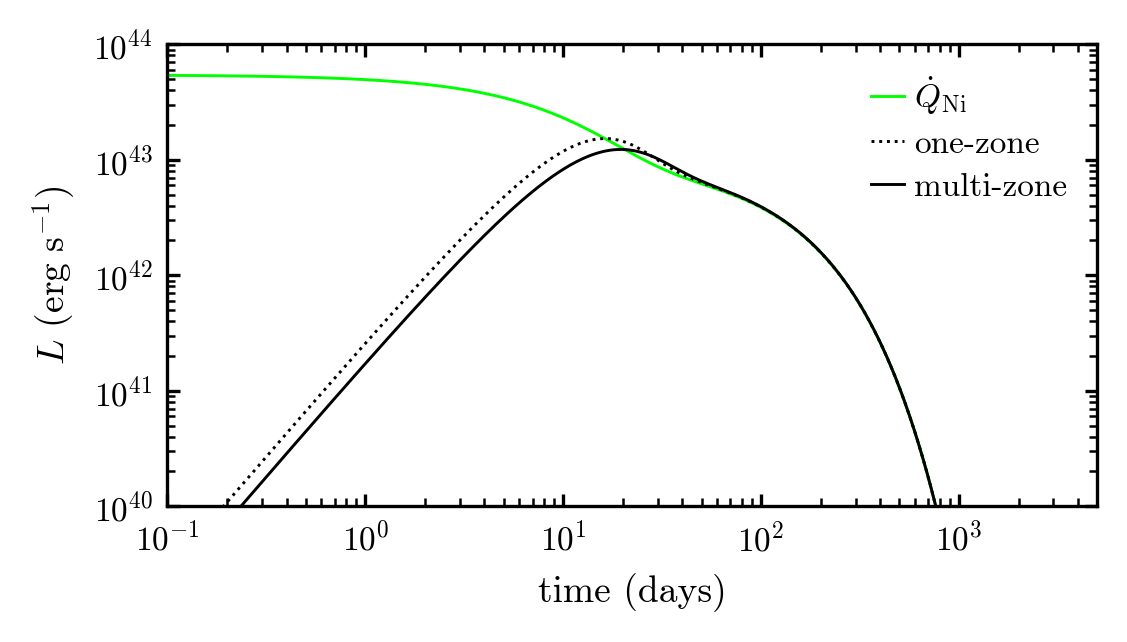

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2.), dpi = 300)

ax.plot(t * SEC_TO_DAY, Qdot_ni, color='lime', linestyle='-', lw = 0.7, label = r'$\dot{Q}_{\rm Ni}$')

# for i in range(N):
#     ax.plot(t/(24 * 60 *60), L_zones[i], color='gray', linestyle='-', lw = 0.7, alpha = 0.1)

ax.plot(t * SEC_TO_DAY, L_onezone, color='black', linestyle=':', lw = 0.7, label = 'one-zone')
ax.plot(t * SEC_TO_DAY, L_tot, color='black', linestyle='-', lw = 0.7, label = 'multi-zone')


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.1, 5e3)
ax.set_ylim(1e40, 1e44)
ax.set_xlabel('time (days)')
ax.set_ylabel(r'$L$ ($\rm erg~s^{-1}$)')
ax.legend()

# plt.savefig('multi.pdf', bbox_inches='tight')
plt.show()

# Exercises

1. What happens when you modify the total eject mass, velocity, opacity in the one-zone model? You can predict these effects using $t_{\rm pk} = \sqrt{M\kappa/4\pi vc}$. Vary the fiducial model parameters and see if the result matches expectations. What happens if you change the nickel mass?

2. Explore the effects of varying the above quantities and their profiles/distributions in the multi-zone model. You should feel free to explore unphysical extremes to see their exaggerated effects on the light curve.

3. **SN2011fe**: Compare the model to bolometric luminosity data from SN2011fe ([Zhang et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...820...67Z/abstract)). Data is attached in "sn2011fe_bol.txt" file. Use a linear time axis.

    a. Adjust the total $^{56}\mathrm{Ni}$ mass in the model to match the peak luminosity from the data. How much nickel do you need?

    b. You should find very good agreement between the early time morphology of the model light curve and the data. However, the model light curve overestimates the late time luminosity. Moreover, the slope of the late time emission in the model (which is the slope of the $^{56}\mathrm{Co}$ decay heating) does not match the observed slope. Why do you think this is?

    c. The late time emission slope in the data follows $ f_{\rm th}(t) e^{-t/t_{\rm Co}} $. The extra factor is $ f_{\rm th} \approx 1-e^{-(t_\gamma/t)^2}$, where $t_\gamma \approx \sqrt{\kappa_\gamma M/4\pi v^2}$ is the time-scale for the ejecta to become optically thin to gamma rays. The opacity for $\sim$MeV gamma radiation is set primarily by Compton scattering, $\kappa_\gamma \approx 0.05~\rm cm^2~g^{-1}$ \citep{Ambwani&Sutherland1988}. Calculate $t_\gamma$ for the model parameters and modify the original heating rate to account for gamma-ray thermalization, $\dot{q}_{\rm th}(t) = f_{\rm th}(t)\dot{q}(t)$. The new light curve slope should show better agreement with the data.

    d. Even with the appropriate light curve slope, you will find that the nickel mass inferred from fitting the peak luminosity still over estimates the late-time luminosity. How much nickel mass do you need to fit the late-time emission? Do your two nickel mass estimates (from fitting the peak emission and from fitting the late-time emission) agree with the corresponding estimates from [Zhang et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...820...67Z/abstract)? See Sec. 5.2 of [Zhang et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...820...67Z/abstract) for a discussion of why the two methods give different estimates of the nickel mass.

4. **Extra heating From $\mathbf{^{57}\!}$ Ni**: Thus far we've assumed that $^{56}\rm Ni$ is the only radioactive isotope synthesized in the explosion. In reality, other unstable iron group nuclei are synthesized and sometimes in significant amounts to affect the light curve. For example, it is known that $^{57}\rm Ni$ can be synthesized in quantities at a few \% of $^{56}\rm Ni$ mass (Graur et al., 2016). The decay chain is $^{57}\rm Ni \rightarrow ^{57}\! \!\rm Co \rightarrow ^{57}\rm \! \!Fe$ and the specific decay rate is given by Eq. 4, with $\epsilon_{\rm Ni} = 1.3\times10^{10}~\rm erg~s^{-1}~g^{-1}$, $\epsilon_{\rm Co} = 6.1\times10^{7}~\rm erg~s^{-1}~g^{-1}$, $t_{\rm Ni} = 2.1~\rm days$, and $t_{\rm Co} = 392~\rm days$. Note the long decay time-scale for $^{57}\rm Co$. How would you expect this to affect the light curve? Add $0.1 M_\odot$ of $^{57}\rm Ni$ to the explosion (in addition to the $^{56}\rm Ni$) and see if it matches your prediction.

5. **$r$-process doped SNe**: Modify the total ejecta mass and ${^{56}\rm Ni}$ mass to model a (hydrogen-poor) core-collapse supernova. It was originally believed that the neutrino driven wind following a successful core-collapse explosion could be an ideal site for the $r$-process (Meyer et al., 1992). Later studies discovered that the physical conditions in "ordinary" neutrino-driven CCSNe could not achieve the physical conditions required for the $r$-process (Qian & Woosley, 1996). However, a robust $r$-process may yet be possible in magneto-rotationally driven explosions (e.g., Mosta et al., 2018) or proto-magnetar winds (Prasanna et al., 2025). Collapsar disk winds may also have prolific $r$-process yields (Siegal et al. 2019). In all cases we would typically expect the $r$-process enriched ejecta to be embedded within the ordinary $r$-process-free supernova ejecta, so we can model the $r$-process distribution in the same way we handle the nickel mixing. The specific heating rate for $r$-process ejecta can be written as a power-law (Metzger et al., 2010), $$ \begin{align} \dot{q}_r \approx 3 \times 10^{10}~\mathrm{erg~s^{-1}~g^{-1}}\bigg( \frac{t}{1~\rm day}\bigg)^{-1.3}, \end{align} $$
and the typical continuum opacity is $10-30~\rm cm^2~g^{-1}$ (Tanaka et al., 2020), depending on the exact composition of $r$-process nuclei. Add this heating function to the multi-zone model and assume $10^{-2} -1 M_\odot$ of $r$-process material is synthesized (in addition to the $^{56}\rm Ni$).

6. **Kilonovae**: There are two ejecta components with distinct properties (mass, velocity, and opacity) in neutron star mergers, producing the "blue" and "red" kilonova components ([Kasen et al., 2017](https://ui.adsabs.harvard.edu/abs/2017Natur.551...80K/abstract)). The total kilonova light curve can be modeled by superimposing one-zone models for each component. Use the heating rate from the previous question and the ejecta properties from ([Kasen et al. 2017](https://ui.adsabs.harvard.edu/abs/2017Natur.551...80K/abstract)) to model a kilonova light curve.